In [1]:
import numpy as np
import tensorflow as tf
import get_model
import mfcc
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display


In [2]:
sr = 8000
train_nums = 28000
hop_length = 128

In [3]:
data = np.load(f"data_set_mfcc_sr_{sr//1000}k_librosa_7808p_ln.npz")
X = data["X"]
y = data["y"]
labels = data["labels"]

In [4]:
print(labels)

['five' 'four' 'go' 'left' 'one' 'right' 'stop' 'three' 'two' 'yes']


In [5]:
y[1]

1.0

In [6]:
#change index to one hot code
y = tf.one_hot(y, np.max(y)+1)
#extend X to 4 d
X = X[:,:,:, np.newaxis]


In [7]:
y[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [8]:
X.shape

(30000, 60, 13, 1)

In [9]:
#splite data 

X_train = X[:train_nums]
X_test  = X[train_nums:]
y_train = y[:train_nums]
y_test  = y[train_nums:]

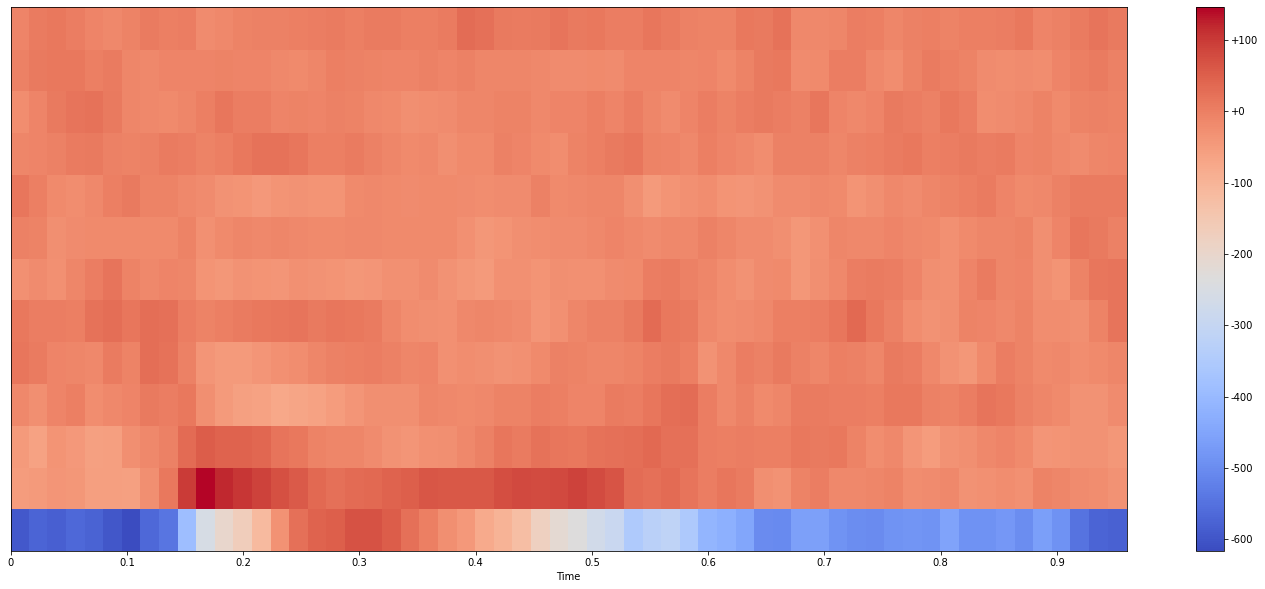

In [10]:

#display some data
plt.figure(figsize=(25, 10))
librosa.display.specshow(X_train[0,:,:,0].T, 
                         x_axis="time", 
                         hop_length=hop_length,
                         sr=sr)
plt.colorbar(format="%+2.f")

In [11]:
model = get_model.get_cnn_model(X_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 11, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 5, 4)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 3, 8)          296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 1, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 104)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [12]:
#compile the model 
model.compile(optimizer="adam" , loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
#define callbacks
callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ModelCheckpoint(f"cnn_model_checkpoints/checkpoint_{sr//1000}k_7808p_ln", save_weights_only=True, save_best_only=True),
]

cnn_history = model.fit(
                    X_train, y_train, 
                    batch_size=128,
                    epochs=300,
                    validation_split=0.1,
                    callbacks= callbacks)

Epoch 1/300
197/197 [==============================] - 3s 11ms/step - loss: 9.8490 - accuracy: 0.1254 - val_loss: 2.3431 - val_accuracy: 0.1829
Epoch 2/300
197/197 [==============================] - 1s 7ms/step - loss: 2.2274 - accuracy: 0.2110 - val_loss: 1.8538 - val_accuracy: 0.3321
Epoch 3/300
197/197 [==============================] - 1s 7ms/step - loss: 1.7892 - accuracy: 0.3639 - val_loss: 1.6294 - val_accuracy: 0.4171
Epoch 4/300
197/197 [==============================] - 1s 7ms/step - loss: 1.5667 - accuracy: 0.4558 - val_loss: 1.4606 - val_accuracy: 0.4925
Epoch 5/300
197/197 [==============================] - 1s 7ms/step - loss: 1.3840 - accuracy: 0.5275 - val_loss: 1.3145 - val_accuracy: 0.5518
Epoch 6/300
197/197 [==============================] - 1s 7ms/step - loss: 1.2115 - accuracy: 0.5925 - val_loss: 1.1396 - val_accuracy: 0.6311
Epoch 7/300
197/197 [==============================] - 1s 7ms/step - loss: 1.0553 - accuracy: 0.6505 - val_loss: 1.0147 - val_accuracy: 0.673

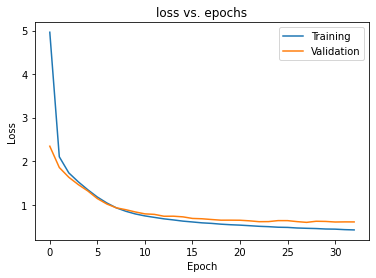

In [14]:
#Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets

#loss
train_loss = cnn_history.history["loss"]
val_loss = cnn_history.history["val_loss"]

plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Validation")

plt.title('loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

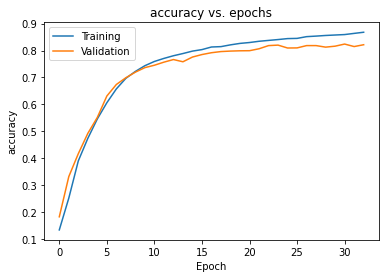

In [15]:
#accuracy
train_loss = cnn_history.history["accuracy"]
val_loss = cnn_history.history["val_accuracy"]

plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.title('accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()

In [16]:
#Compute and display the loss and accuracy of the trained model on the test set
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.6481 - accuracy: 0.7975


[0.6481474041938782, 0.7975000143051147]

In [17]:
#test my voice
sample, _ = librosa.load("one.wav", sr=sr)
IPython.display.Audio(sample, rate=sr)


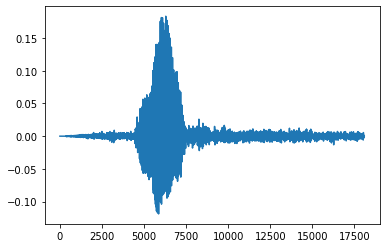

In [18]:
plt.plot(sample)

In [19]:
#extract MFCCs
sample = sample[:7808] 
sample_mfccs = mfcc.get_mfcc(sample, sr, n_fft=256, hop_length=128, n_mels=26, mfcc_n=13)
#sample_mfccs = librosa.feature.mfcc(sample.T, n_mfcc=13, sr=sr,  center=False, n_fft=256, hop_length=128, n_mels=26).T

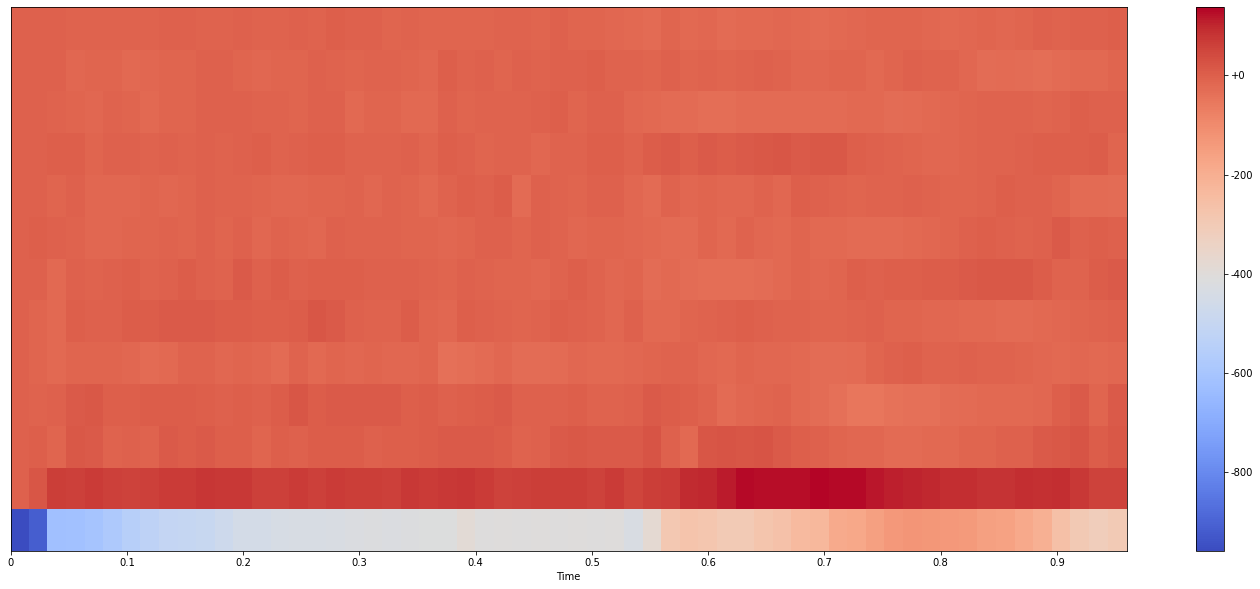

In [20]:
#display 
sample_mfccs = sample_mfccs[np.newaxis, :,:,np.newaxis]

plt.figure(figsize=(25, 10))
librosa.display.specshow(sample_mfccs[0,:,:,0].T, 
                         x_axis="time", 
                         hop_length=hop_length,
                         sr=sr)
plt.colorbar(format="%+2.f")

In [21]:
sample_y = labels[np.argmax(model(sample_mfccs))]
confidence = np.max(model(sample_mfccs))
print(f"you just said {sample_y}({confidence})")


you just said one(0.6975705027580261)


In [22]:
sample_mfccs.shape

(1, 60, 13, 1)

In [28]:
#test my voice2
sample2, _ = librosa.load("three.wav", sr=sr) 
sample2 = sample2 * 10
IPython.display.Audio(sample2[0:10000], rate=sr)


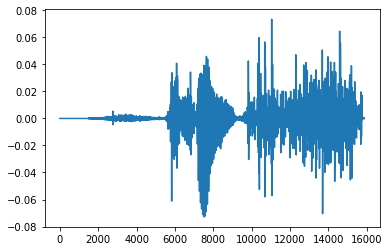

In [29]:
plt.plot(sample2)

In [30]:
#extract MFCCs
sample_mfccs2 = mfcc.get_mfcc(sample2[1000:8808], sr, n_fft=256, hop_length=128, n_mels=26, mfcc_n=13)
#sample_mfccs2 = librosa.feature.mfcc(sample2[:7808].T, n_mfcc=13, sr=sr,  center=False, n_fft=256, hop_length=128, n_mels=26).T
sample_mfccs2.shape


(60, 13)

(1, 60, 13, 1)


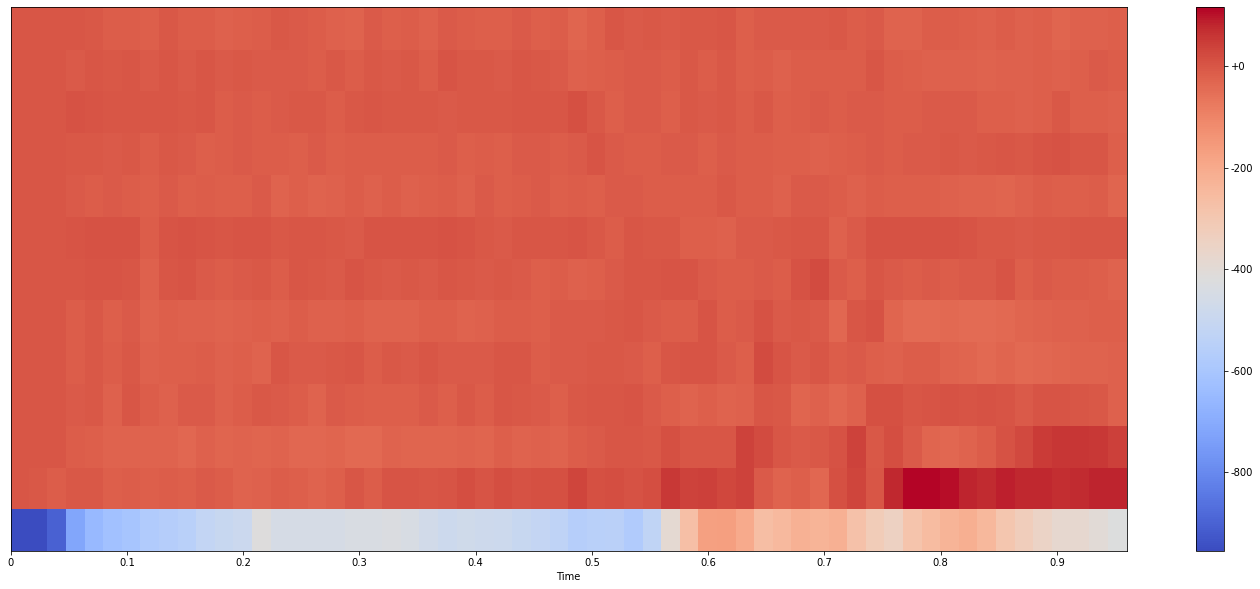

In [31]:
#display 
sample_mfccs2 = sample_mfccs2[np.newaxis, :,:,np.newaxis]
print(sample_mfccs2.shape)
plt.figure(figsize=(25, 10))
librosa.display.specshow(sample_mfccs2[0,:,:,0].T, 
                         x_axis="time", 
                         hop_length=128,
                         sr=sr)
plt.colorbar(format="%+2.f")

In [32]:
sample_y2 = labels[np.argmax(model(sample_mfccs2))]
confidence2 = np.max(model(sample_mfccs2))
print(f"you just said {sample_y2}({confidence2})")


you just said three(0.9712802767753601)


In [44]:
print(y[:10])

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


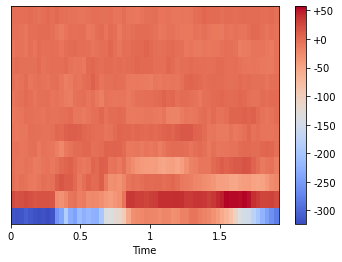

In [30]:
librosa.display.specshow(X[0,:,:,0].T, 
                         x_axis="time", 
                         hop_length=256,
                         sr=sr)
plt.colorbar(format="%+2.f")

In [32]:
path = "C:/Users/zhang/Desktop/speech_commands_v0.02/_background_noise_"

In [33]:
#test my voice2
sample2, _ = librosa.load(f"{path}/doing_the_dishes.wav", sr=sr)
IPython.display.Audio(sample2, rate=sr)

In [70]:
sample_mfccs = mfcc.get_mfcc(sample2[13*16000:14*16000], sr, n_fft=512, hop_length=256, n_mels=26, mfcc_n=13)

In [71]:
predict = model(sample_mfccs[np.newaxis, :, :, np.newaxis])
sample_y = labels[np.argmax(predict)]
confidence = np.max(predict)
print(f"you just said {sample_y}({confidence})")

you just said five(0.6500545144081116)


In [36]:
x = X_test[0:3]
y = y_test[0:3]

In [37]:
y

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [40]:
x.shape

(3, 61, 13, 1)

In [39]:
predict = model(x[:, :])

In [41]:
predict

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[1.0702471e-12, 3.9074556e-07, 1.9252385e-03, 1.9950166e-06,
        2.7914155e-06, 1.2308877e-04, 2.9142105e-11, 6.8154482e-06,
        3.9192550e-02, 9.5874715e-01],
       [8.2482043e-17, 9.1702768e-14, 2.0797613e-09, 1.9619610e-07,
        4.1022594e-13, 3.7465051e-15, 4.1483578e-14, 5.2092886e-16,
        2.0142244e-13, 9.9999976e-01],
       [2.1532055e-06, 3.0260144e-03, 9.8351824e-01, 5.8192050e-05,
        3.5551195e-05, 1.4778054e-07, 5.1964638e-03, 1.2196715e-07,
        8.1542777e-03, 8.9574214e-06]], dtype=float32)>